# Siamese Recurrent Architectures - MALSTM with Attention

In this notebook we evaluate how MALSTM architecture proposed in [this paper](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023) can be improved in sentence similarity task using SICK and STS datasets with an attention layer. 

### Loading Data

#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [1]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]


,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]


,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


### Loading Embeddings
3 word embeddings were used for this experiment. Word2vec, Glove and fasttext.

#### Loading word2vec

In [3]:
from embeddings.load_embeddings import load_word2vec

word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")


#### Loading Glove
To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model.

In [4]:
from embeddings.load_embeddings import load_glove

glove = load_glove("/data/glove/glove.840B.300d.txt")


#### Loading Fasttext
To load Fasttext, we used genism library

In [5]:
from embeddings.load_embeddings import load_fasttext

fasttext = load_fasttext("/data/fasttext/crawl-300d-2M-subword.vec")


#### Preparing Optimizers
Following optimizers were used to the neural network architecture.

In [5]:
from keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam

gradient_clipping_norm = 1.25

adadelta = Adadelta(clipnorm=gradient_clipping_norm)
sgd = SGD(clipnorm=gradient_clipping_norm)
rmsprop = RMSprop(clipnorm=gradient_clipping_norm)
adagrad = Adagrad(clipnorm=gradient_clipping_norm)
adam = Adam(clipnorm=gradient_clipping_norm)
adamax = Adamax(clipnorm=gradient_clipping_norm)
nadam = Nadam(clipnorm=gradient_clipping_norm)


## MALSTM-ATTENTION with Adadelta
We check the network with three word embeddings using adadelta optimizer.

1. MALSTM-ATTENTION  with Word2vec (As original Paper)
2. MALSTM-ATTENTION  with Glove
3. MALSTM-ATTENTION  with Fasttext

In [7]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-ATTENTION-W2V-ADADELTA",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta,
                          model=word2vec)),
              ("LSTM-ATTENTION-GLOVE-ADADELTA",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta,
                          model=glove)),
              ("LSTM-ATTENTION-FASTTEXT-ADADELTA",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:84: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


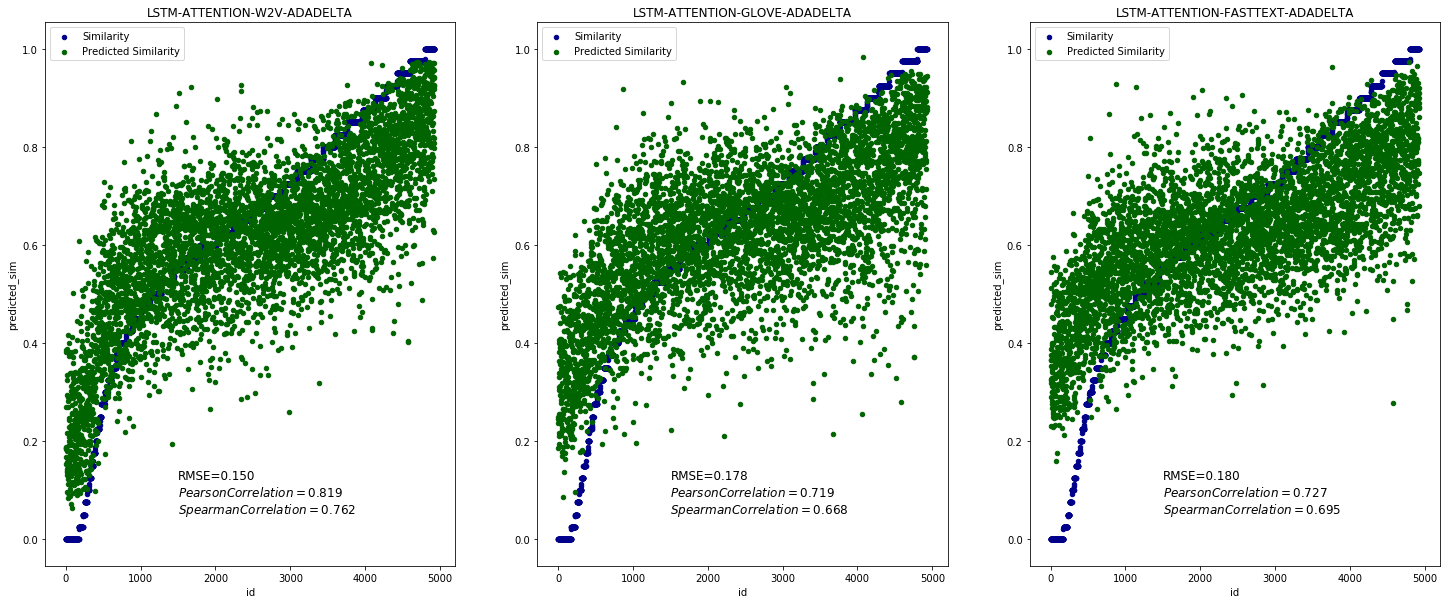

In [9]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if (i < 3):
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## MALSTM-ATTENTION with SGD
We check the network with three word embeddings using sgd optimizer.

1. MALSTM-ATTENTION with Word2vec
2. MALSTM-ATTENTION with Glove
3. MALSTM-ATTENTION with Fasttext

In [13]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-ATTENTION-W2V-SGD", ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch,
                                          optimizer=sgd, model=word2vec)),
              ("LSTM-ATTENTION-GLOVE-SGD",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd,
                          model=glove)),
              ("LSTM-ATTENTION-FASTTEXT-SGD",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


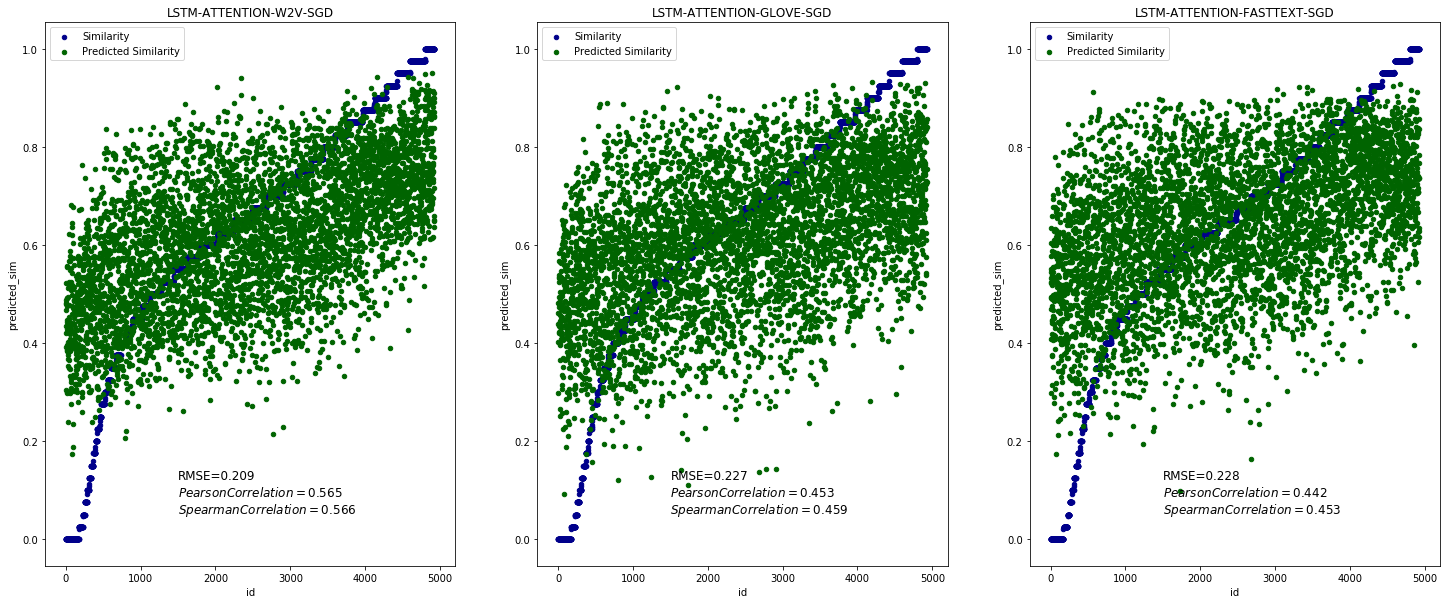

In [14]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
        rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if i < 3:
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## MALSTM-ATTENTION with RMSPROP
We check the network with three word embeddings using rmsprop optimizer.

1. MALSTM-ATTENTION with Word2vec
2. MALSTM-ATTENTION with Glove
3. MALSTM-ATTENTION with Fasttext

In [15]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-ATTENTION-W2V-RMSPROP",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop,
                          model=word2vec)),
              ("LSTM-ATTENTION-GLOVE-RMSPROP",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop,
                          model=glove)),
              ("LSTM-ATTENTION-FASTTEXT-RMSPROP",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


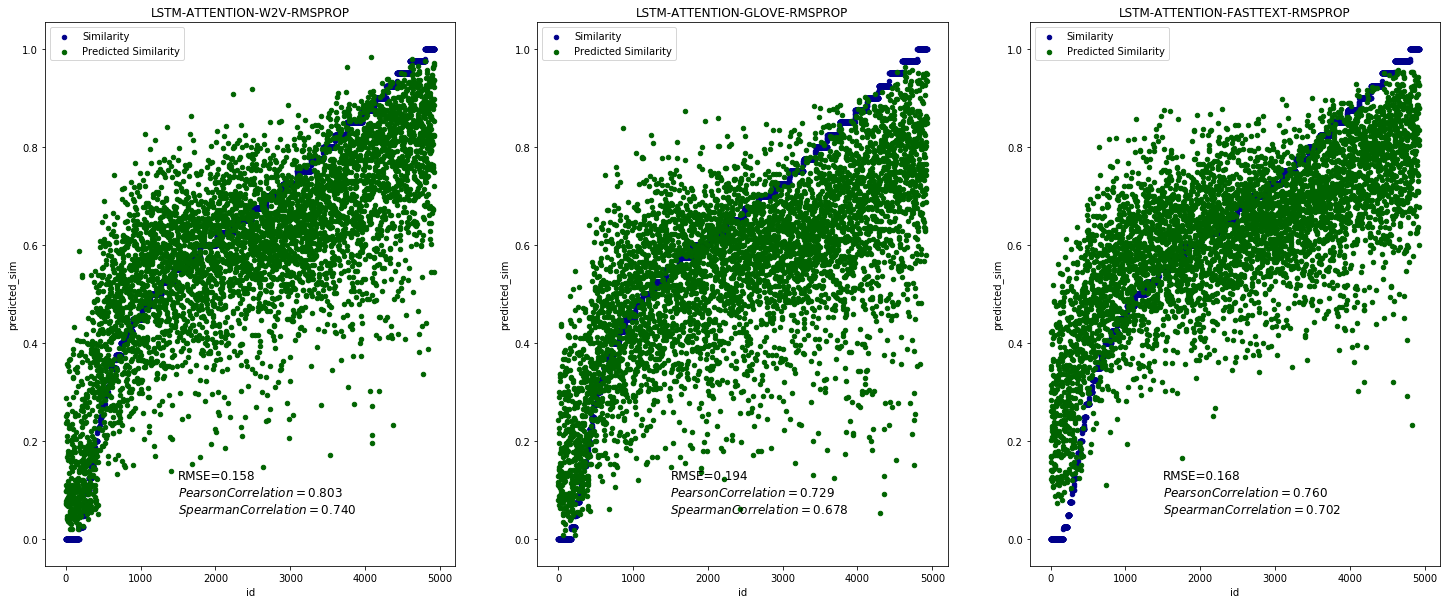

In [16]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if i < 3:
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## MALSTM-ATTENTION with ADAGRAD
We check the network with three word embeddings using adagrad optimizer.

1. MALSTM-ATTENTION with Word2vec
2. MALSTM-ATTENTION with Glove
3. MALSTM-ATTENTION with Fasttext

In [17]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-ATTENTION-W2V-ADAGRAD",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad,
                          model=word2vec)),
              ("LSTM-ATTENTION-GLOVE-ADAGRAD",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad,
                          model=glove)),
              ("LSTM-ATTENTION-FASTTEXT-ADAGRAD",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


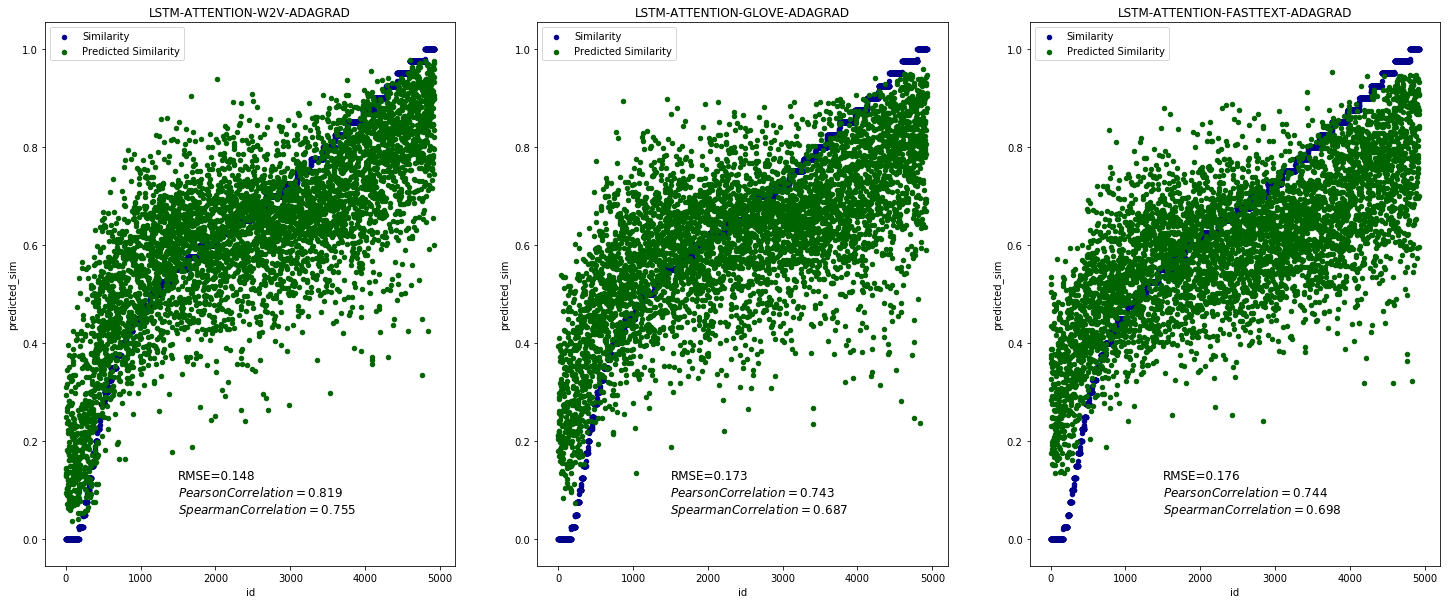

In [18]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if (i < 3):
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## MALSTM-ATTENTION with ADAM
We check the network with three word embeddings using adam optimizer.

1. MALSTM-ATTENTION with Word2vec
2. MALSTM-ATTENTION with Glove
3. MALSTM-ATTENTION with Fasttext

In [19]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-ATTENTION-W2V-ADAM", ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                                           embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch,
                                           optimizer=adam, model=word2vec)),
              ("LSTM-ATTENTION-GLOVE-ADAM",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam,
                          model=glove)),
              ("LSTM-ATTENTION-FASTTEXT-ADAM",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


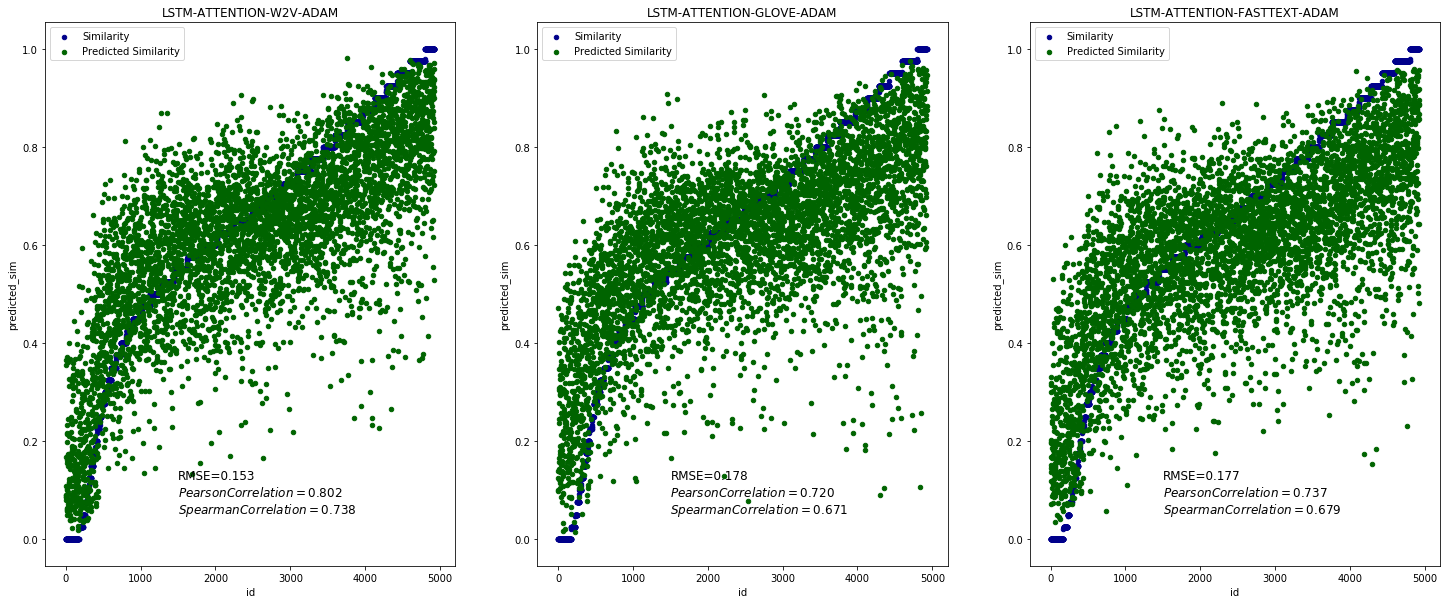

In [20]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if (i < 3):
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## MALSTM-ATTENTION with ADAMAX
We check the network with three word embeddings using adamax optimizer.

1. MALSTM-ATTENTION with Word2vec
2. MALSTM-ATTENTION with Glove
3. MALSTM-ATTENTION with Fasttext

In [22]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-ATTENTION-W2V-ADAMAX",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax,
                          model=word2vec)),
              ("LSTM-ATTENTION-GLOVE-ADAMAX",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax,
                          model=glove)),
              ("LSTM-ATTENTION-FASTTEXT-ADAMAX",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


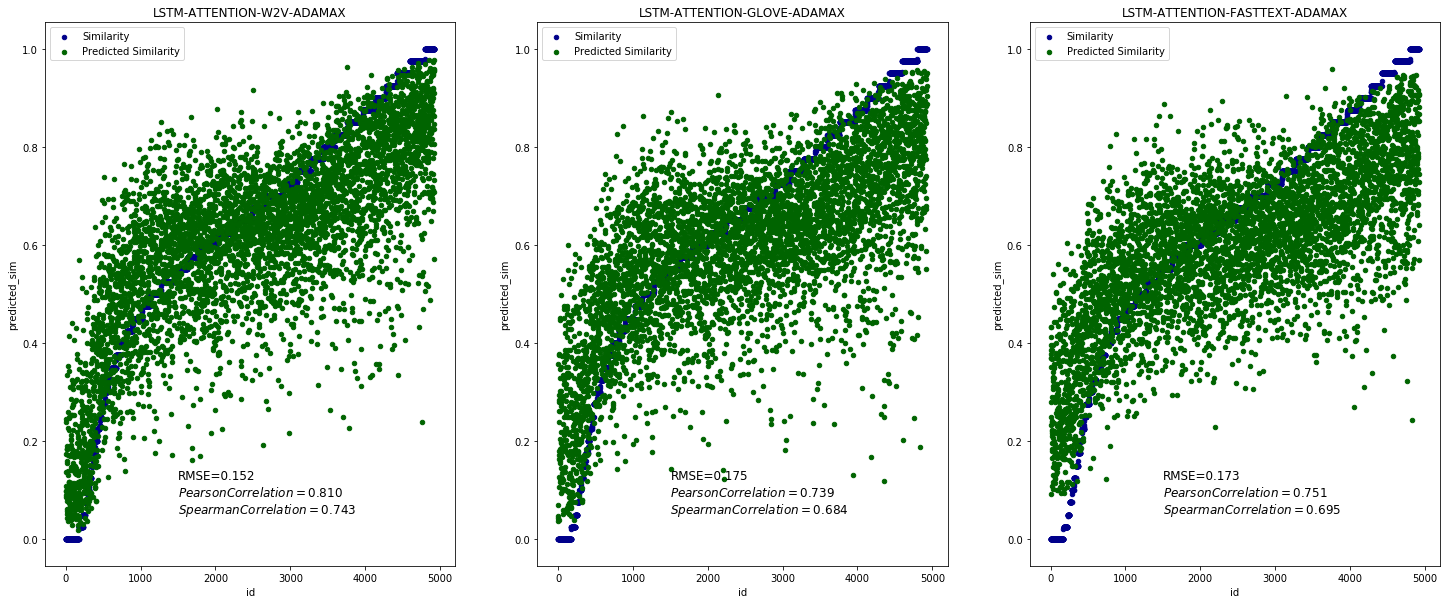

In [23]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if (i < 3):
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## MALSTM-ATTENTION with NADAM
We check the network with three word embeddings using nadam optimizer.

1. MALSTM-ATTENTION with Word2vec
2. MALSTM-ATTENTION with Glove
3. MALSTM-ATTENTION with Fasttext

In [24]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 100

benchmarks = [("LSTM-W2V-NADAM",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam,
                          model=word2vec)),
              ("LSTM-GLOVE-NADAM",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam,
                          model=glove)),
              ("LSTM-FASTTEXT-NADAM",
               ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam,
                          model=fasttext))]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


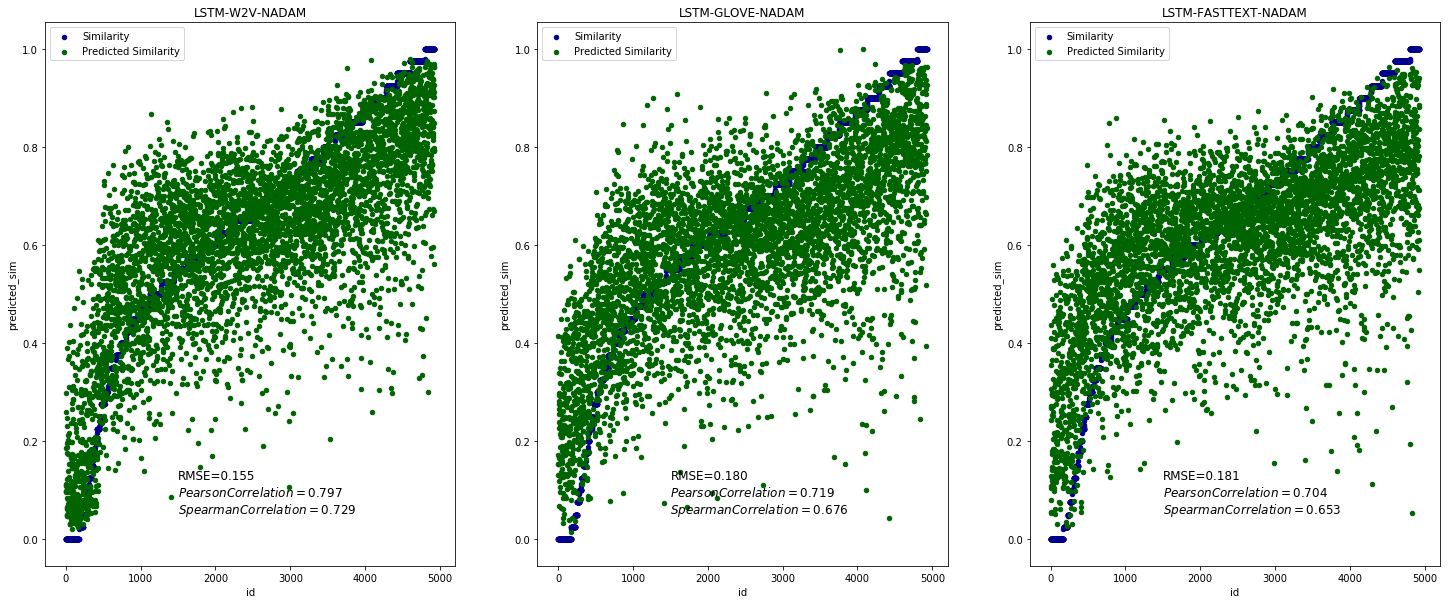

In [25]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if (i < 3):
        row = 0
        column = i

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)


## Conclusions
MALSTM-ATTENTION worked genrally good with word2vec models other than glove and fasttext. 
Adding attention on top of LSTM improved the performance with every optimizer. The best performance we got from the MALSTM was 0.153 RMSE in contrast to the 0.148 RMSE we got here with Adagrad optimizer

## MALSTM-ATTENTION - Transfer Learning

LSTMs generally works better if we can load the pre trained weights using transfer learning rather than random initialization. We first trained the MALSTM Attention model with STS data and then saved it. When we are training for the sick dataset we loaded those saved weights.

This experiment was done only for word2vec embeddings since the other embeddings didn't come closer in previous experiments. Did the experiments for all the optimizers other than SGD since it failed in the last experiment. 

In [6]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 500
max_seq_length = 100

pre_benchmarks = [("LSTM-ATTENTION-W2V-ADADELTA",
                   ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                              embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta,
                              save_weights="models/lstm_attention_w2v_adadelta_weights.h5", load_weights=None, max_seq_length=max_seq_length, model=word2vec)),
                  ("LSTM-ATTENTION-W2V-RMSPROP",
                   ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                              embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop,
                              save_weights="models/lstm_attention_w2v_rmsprop_weights.h5", load_weights=None, max_seq_length=max_seq_length,model=word2vec)),
                  ("LSTM-ATTENTION-W2V-ADAGRAD",
                   ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                              embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad,
                              save_weights="models/lstm_attention_w2v_adagrad_weights.h5", load_weights=None, max_seq_length=max_seq_length,model=word2vec)),
                 ("LSTM-ATTENTION-W2V-ADAM",
                   ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                              embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam,
                              save_weights="models/lstm_attention_w2v_adam_weights.h5", load_weights=None, max_seq_length=max_seq_length,model=word2vec)),
                 ("LSTM-ATTENTION-W2V-ADAMAX",
                   ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                              embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax,
                              save_weights="models/lstm_attention_w2v_adamax_weights.h5", load_weights=None, max_seq_length=max_seq_length,model=word2vec)),
                 ("LSTM-ATTENTION-W2V-NADAM",
                   ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                              embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam,
                              save_weights="models/lstm_attention_w2v_nadam_weights.h5", load_weights=None, max_seq_length=max_seq_length,model=word2vec))]

benchmarks = [("LSTM-ATTENTION-W2V-ADADELTA",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adadelta_weights.h5", max_seq_length=max_seq_length, model=word2vec)),
              ("LSTM-ATTENTION-W2V-RMSPROP",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop,
                          save_weights=None, load_weights="models/lstm_attention_w2v_rmsprop_weights.h5", max_seq_length=max_seq_length, model=word2vec)),
              ("LSTM-ATTENTION-W2V-ADAGRAD",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adagrad_weights.h5", max_seq_length=max_seq_length, model=word2vec)),
             ("LSTM-ATTENTION-W2V-ADAM",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adam_weights.h5", max_seq_length=max_seq_length, model=word2vec)),
             ("LSTM-ATTENTION-W2V-ADAMAX",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adamax_weights.h5", max_seq_length=max_seq_length, model=word2vec)),
             ("LSTM-ATTENTION-W2V-NADAM",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam,
                          save_weights=None, load_weights="models/lstm_attention_w2v_nadam_weights.h5", max_seq_length=max_seq_length, model=word2vec))]


In [ ]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
row = 0
column = 0
sts_all = sts_dev.append(sts_test, ignore_index=True)
sts_all_normalized = normalize(sts_all, ["sim"])
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 6):
    sts_sims, sts_trained_model, topic = run_experiment(sts_all_normalized, sts_all_normalized, ['sent_1', 'sent_2'],
                                                        "sim", pre_benchmarks[i])
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if i < 3:
        row = 0
        column = i
    
    if(i >= 3 and i < 6):
        row = 1
        column = i-3

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[row][column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[row][column]);
    axes[row][column].text(1500, 0.05, textstr, fontsize=12)


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm_attention.py:86: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


## Conclusions
As in the original paper MALSTM was improved when using tranfer learning. The model was first trained using STS dataset and loaded the weights when training for SICK Dataset.

## MALSTM-ATTENTION with thesaurus-based augmentation and transfer learning

Thesaurus based augmentation is a good way to extend the training set. We extended the training set using thesaures based augmentation to double the size of the available training set of SICK data. And then we loaded the pre-trained weights saved from STS data and trained the network. 

We used only word2vec embeddings for the experiment and used all the optimzers other than Adadelta.

In [28]:
import pandas as pd

sick_aug = pd.read_csv("data/sick_aug.csv", header=0)
sick_aug[:10]


,sent_1,sent_2,sim,label,rand_id
0,A man is typing on a machine used for stenography,There is no person riding a bike along a muddy...,1.0,NEUTRAL,9974.0
1,Two men are leaving the stage,Mimes are performing on a stage,3.1,NEUTRAL,1552.0
2,A man is wearing a purple shirt and black leat...,A model is wearing a purple shirt and black le...,4.4,ENTAILMENT,9393.0
3,A man is playing a keyboard in a park,A person is playing the keyboard,4.3,ENTAILMENT,1373.0
4,A cat is playing with a small bottle,A bottle is being licked by the cat,3.5,NEUTRAL,5664.0
5,A poor man is being fed snakes and mice,A snake is being fed a mouse by a man,2.3,NEUTRAL,1609.0
6,Two white dogs and one brown dog are chasing a...,Two white dogs and one brown dog are chasing a...,4.5,ENTAILMENT,7887.0
7,A group of mothers in uniforms is standing nea...,A group of children in uniforms is standing at...,3.3,NEUTRAL,315.0
8,Two men are riding an orange raft on the shore,Two men are getting off of an orange raft on t...,4.2,NEUTRAL,6460.0
9,There is no woman tapping her fingers,A woman is tapping her fingers on a table,3.8,CONTRADICTION,2233.0


In [35]:
import functools as ft

from nn.lstm_attention import run_lstm_attention_benchmark

validation_portion = 0.1
n_hidden = 100
embedding_dim = 300
batch_size = 64
n_epoch = 500


benchmarks = [("LSTM-ATTENTION-W2V-ADADELTA",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adadelta_weights.h5", model=word2vec)),
              ("LSTM-ATTENTION-W2V-RMSPROP",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop,
                          save_weights=None, load_weights="models/lstm_attention_w2v_rmsprop_weights.h5", model=word2vec)),
              ("LSTM-ATTENTION-W2V-ADAGRAD",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adagrad_weights.h5", model=word2vec)),
             ("LSTM-ATTENTION-W2V-ADAM",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adam_weights.h5", model=word2vec)),
             ("LSTM-ATTENTION-W2V-ADAMAX",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax,
                          save_weights=None, load_weights="models/lstm_attention_w2v_adamax_weights.h5", model=word2vec)),
             ("LSTM-ATTENTION-W2V-NADAM",
              ft.partial(run_lstm_attention_benchmark, validation_portion=validation_portion, n_hidden=n_hidden,
                          embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam,
                          save_weights=None, load_weights="models/lstm_attention_w2v_nadam_weights.h5", model=word2vec)),]


/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


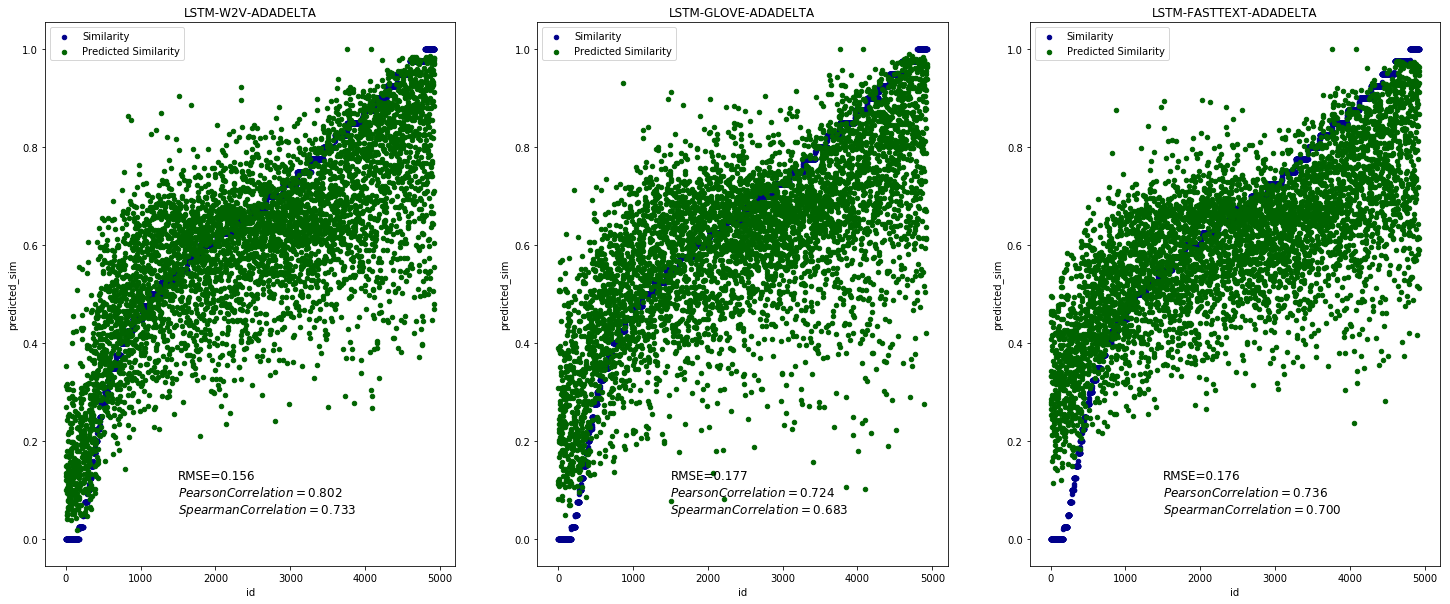

In [36]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import mean_squared_error

from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
row = 0
column = 0

sick_train_normlized = normalize(sick_aug, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 6):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim",
                                                benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$' % (
    rmse, pearson_correlation, spearman_correlation)
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values

    if i < 3:
        row = 0
        column = i
    
    if(i >= 3 and i < 6):
        row = 1
        column = i-3

    sick_test_sorted.plot(kind='scatter', x='id', y='sim', color='DarkBlue', label='Similarity', title=topic,
                          ax=axes[row][column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity',
                          ax=axes[row][column]);
    axes[row][column].text(1500, 0.05, textstr, fontsize=12)


## Conclusions
As in the original paper MALSTM was improved when using tranfer learning and thesaurus-based augmentation for the training set.